In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('dark')

In [11]:
df = pd.read_csv('Default.csv').iloc[:,1:].dropna()

In [12]:
# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()



Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]

In [13]:
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.57387391644
[  1.36988466e-02  -7.57859433e-01  -3.25298557e-04]
0.573946428961

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


In [14]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.443633767129

Parameter estimates for the model with many features:
[  0.00000000e+00  -3.89351238e-01   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -2.77688887e-04
  -7.09158792e-07   3.48711577e+00]


In [15]:
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))
print('\n')
print(lass.score(X_test, Y_test))
print(lassBig.score(X_test2, Y_test))

0.563108876308
0.563180432393


0.445532251512
0.438046634591


In [16]:
ridgescores = []

lassscores = []


for alphavalue in np.arange(0, 1, 0.01):
    ridgeregrBig = linear_model.Ridge(alpha=alphavalue, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    
    lassBig = linear_model.Lasso(alpha=alphavalue)
    lassBig.fit(X_train2, Y_train)
    
    ridgescores.append(ridgeregrBig.score(X_test2, Y_test))
    lassscores.append(lassBig.score(X_test2, Y_test))

/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.848120e-23
  overwrite_a=True).T
/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small

/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.074323e-16
  overwrite_a=True).T
/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.093089e-16
  overwrite_a=True).T


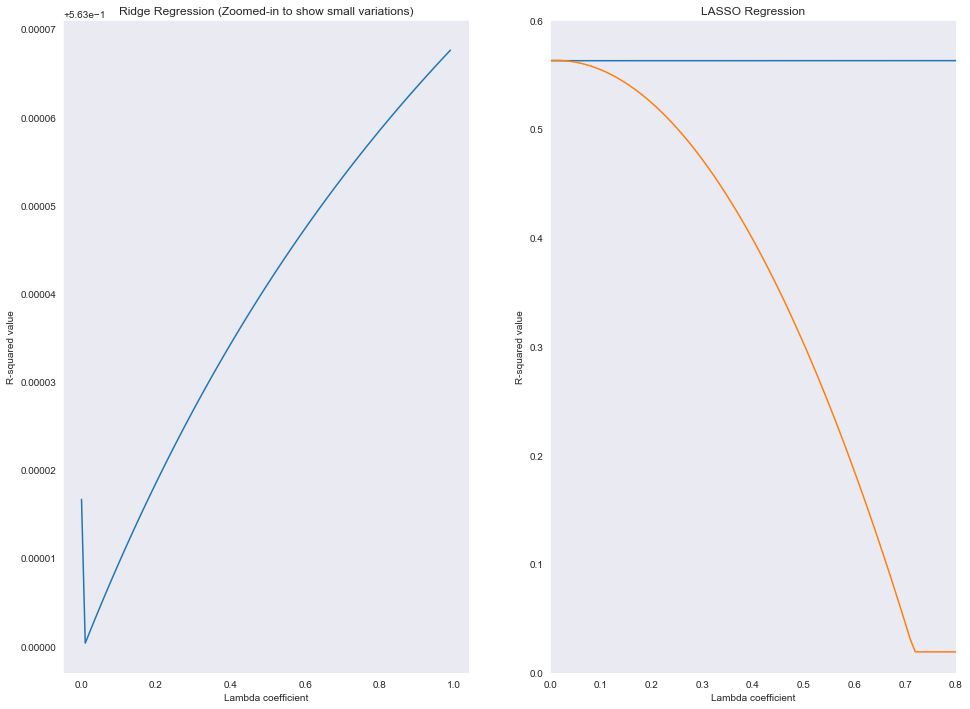

In [29]:
plt.rcParams['figure.figsize'] = 16, 12

plt.subplot(1, 2, 1)

plt.title('Ridge Regression (Zoomed-in to show small variations)')
plt.ylabel('R-squared value')
plt.xlabel('Lambda coefficient')
plt.plot(np.arange(0, 1, 0.01), ridgescores)

plt.subplot(1, 2, 2)

plt.title('LASSO Regression')
plt.ylabel('R-squared value')
plt.xlabel('Lambda coefficient')
plt.xlim(0, 0.8)
plt.ylim(0, 0.6)
plt.plot(np.arange(0, 1, 0.01), ridgescores)
plt.plot(np.arange(0, 1, 0.01), lassscores)

plt.show()

LASSO Regression drops off wildly with higher lambda values, while ridge regression remains fairly constant. There appears to be an intercept close to zero, but ridge regression yielded a warning at low lambda values.